In [1]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

In [2]:
# User input for image resolution
px = 256
img_size = (px,px)

In [3]:
# Set the path to the dataset directory
data_file = "AI_And_Classes"  # Replace with the actual path to your dataset
data_dir = f"Datasets/{data_file}"

In [4]:
# Define the Fourier transform filter function
def fourier_filter(image_tensor):
    channels = []
    for c in range(image_tensor.shape[0]):
        # Apply Fourier transform to each channel separately
        channel_np = image_tensor[c].numpy()
        f_transform = np.fft.fft2(channel_np)
        f_shifted = np.fft.fftshift(f_transform)

        # Define a filter in the frequency domain (e.g., low-pass filter)
        rows, cols = f_shifted.shape
        crow, ccol = rows // 2 , cols // 2
        mask = np.zeros((rows, cols), np.uint8)
        mask[crow - 30:crow + 30, ccol - 30:ccol + 30] = 1  # Adjust filter size as needed

        # Apply the mask to the Fourier transformed channel
        f_shifted = f_shifted * mask

        # Inverse Fourier transform to get the filtered image
        f_ishifted = np.fft.ifftshift(f_shifted)
        filtered_channel = np.fft.ifft2(f_ishifted)
        filtered_channel = np.abs(filtered_channel)
            
        # Append the processed channel
        channels.append(torch.tensor(filtered_channel))

    # Stack the channels back together
    return torch.stack(channels)

In [5]:
# Define the edge detection/high-pass filter function
def high_pass_filter(image_tensor):
    channels = []
    
    for c in range(image_tensor.shape[0]):
        # Convert the channel tensor to a numpy array
        channel_np = image_tensor[c].numpy()
        
        # Step 1: Apply Gaussian blur to get the low-frequency components
        blurred = gaussian_filter(channel_np, sigma=2)
        
        # Step 2: Subtract the blurred image from the original image to get high-frequency components
        high_pass = channel_np - blurred
        
        # Normalize the result to ensure values are within the correct range (optional, for better visibility)
        high_pass = (high_pass - high_pass.min()) / (high_pass.max() - high_pass.min())

        # Append the processed channel to the list and convert to a PyTorch tensor
        channels.append(torch.tensor(high_pass, dtype=torch.float32))

    # Stack the processed channels back into a single tensor
    return torch.stack(channels)

In [6]:
# Define function that plots multiple images in an array of images
def PlotImages(ix_start,num_img,rows,cols,images,labels,label_names,color=True):
    plt.figure(figsize=(10,10))
    plt.subplots_adjust(wspace=0.5,hspace=0.5)
    for i in range(num_img):
        plt.subplot(rows,cols,i+1)
        plt.axis('off')
        if color:
            plt.imshow(images.permute(0, 2, 3, 1)[ix_start+i])
        else: 
            plt.imshow(np.squeeze(images[ix_start+i]),cmap='Greys')
        plt.title(label_names[labels[ix_start+i]])

# Image loader and scaler for image exploration
batch_size = 25

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0024604562..1.8406363].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.020773197..2.0788682].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0033521096..2.180576].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0014783776..2.370707].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00018841305..2.080501].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00032364615..2.2370973].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range 

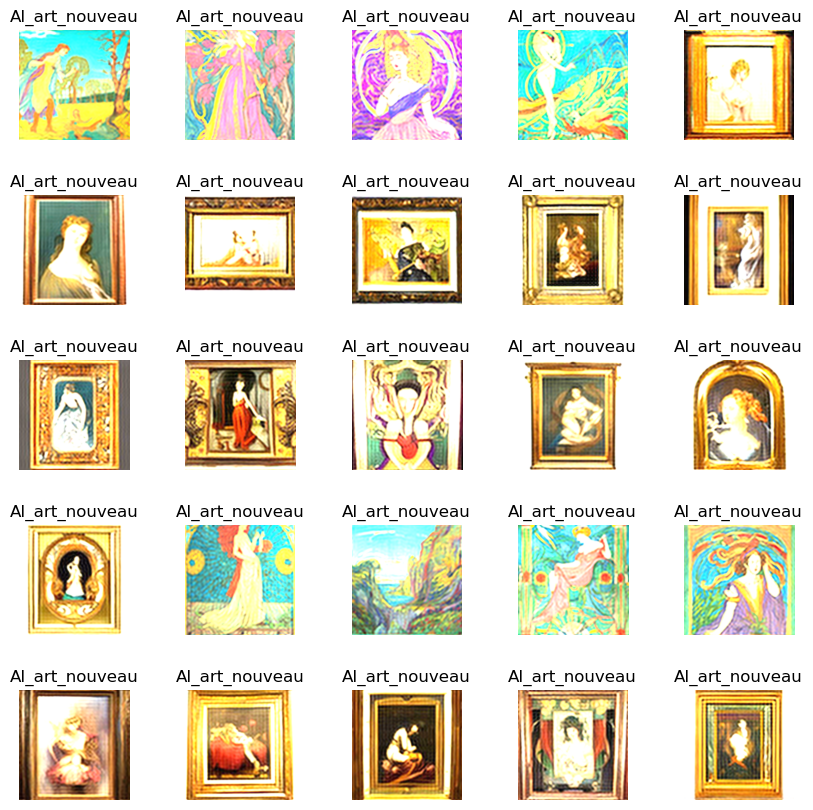

In [8]:
load_image = transforms.Compose([
    transforms.Resize((px, px)),
    transforms.ToTensor(),
    transforms.Lambda(lambda img: fourier_filter(img)),  # Apply the Fourier filter
    transforms.Normalize(
        mean=[0, 0, 0], std=[0.5, 0.5, 0.5]
    )
])
dataset = ImageFolder(root=data_dir, transform=load_image)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
data_iter = iter(dataloader)
label_names = dataset.classes

images, labels = next(data_iter)
next(data_iter)
PlotImages(0,batch_size,5,5,images,labels,label_names,color=True)

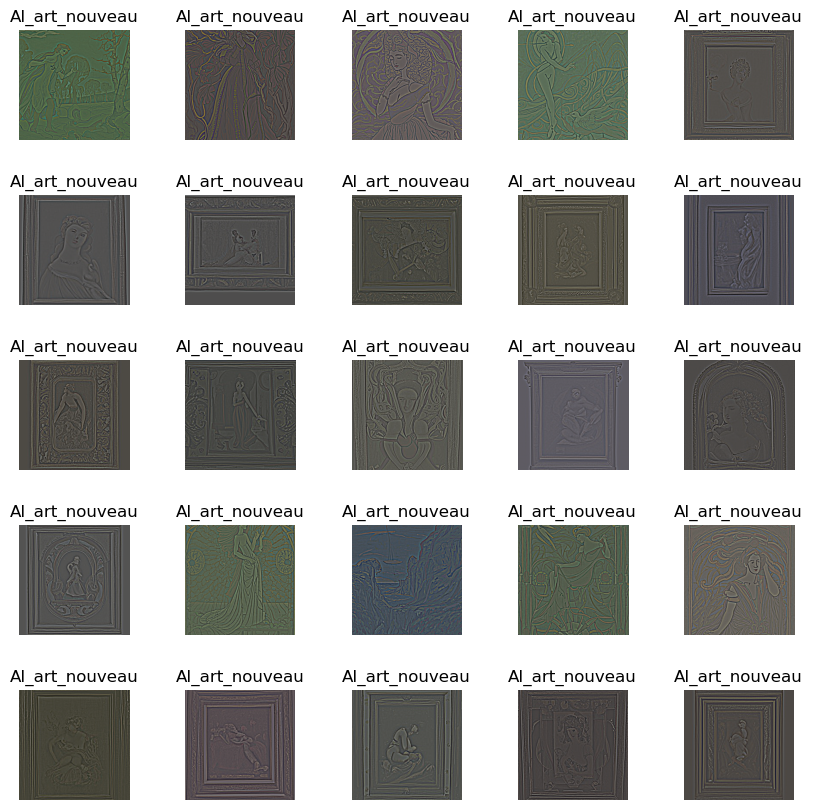

In [8]:
load_image = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Lambda(lambda img: high_pass_filter(img)),  # Apply the wavelet filter
    transforms.Normalize(
        mean=[0, 0, 0], std=[1.5, 1.5, 1.5]
    )
])
dataset = ImageFolder(root=data_dir, transform=load_image)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
data_iter = iter(dataloader)
label_names = dataset.classes

images, labels = next(data_iter)
next(data_iter)
PlotImages(0,batch_size,5,5,images,labels,label_names,color=True)

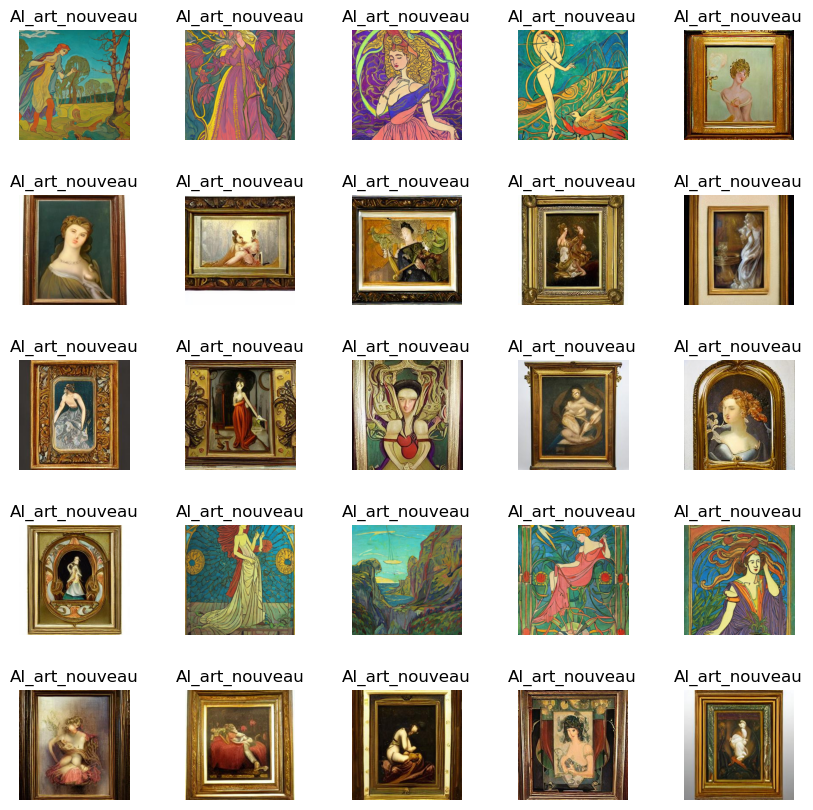

In [9]:
load_image = transforms.Compose([
    transforms.Resize((px, px)),
    transforms.ToTensor()
])
dataset = ImageFolder(root=data_dir, transform=load_image)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
data_iter = iter(dataloader)
label_names = dataset.classes

images, labels = next(data_iter)
next(data_iter)
PlotImages(0,batch_size,5,5,images,labels,label_names,color=True)

In [10]:
# Define a function to extract features using VGG16
def extract_features(data_dir, img_size, filter, batch_size=512, device='cuda:0' if torch.cuda.is_available() else 'cpu'):
    """
    Extract features from images using the convolutional layers of the VGG16 network.
    
    Args:
        data_dir (str): Directory containing the image dataset. Each class should have its own subfolder.
        img_size (tuple): The resolution (width, height) of the images to resize.
        batch_size (int): Number of images to process in one batch.
        device (str): The device to run the model on, 'cuda' or 'cpu'.
        
    Returns:
        features (numpy.ndarray): Extracted features from the images.
        labels (list): Corresponding class labels for each extracted feature.
    """

    # Load the pre-trained VGG16 model
    resnet = models.resnet152(weights='ResNet152_Weights.DEFAULT')

    # Only use the convolutional layers (remove the fully connected layers)
    # VGG16 features have conv layers + pooling
    resnet_features = nn.Sequential(*list(resnet.children())[:-1]).to(device)

    # Disable gradient calculations since we're only using the model for feature extraction
    for param in resnet_features.parameters():
        param.requires_grad = False

    # Define the image transformation pipeline
    transform = transforms.Compose([
        transforms.Resize(img_size),      # Resize to the specified resolution
        transforms.ToTensor(),            # Convert images to PyTorch tensors
        transforms.Normalize(             # Normalize images to match VGG16 input requirements
            mean=[0.485, 0.456, 0.406],   # These are the mean values for VGG16's training data (ImageNet)
            std=[0.229, 0.224, 0.225]     # These are the standard deviations for ImageNet
        )
    ])
    if filter == 1:
        transform = transforms.Compose([
            transforms.Resize((px, px)),
            transforms.ToTensor(),
            transforms.Lambda(lambda img: fourier_filter(img)),  # Apply the Fourier filter
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])
    else: 
        if filter == 2:
            transform = transforms.Compose([
                transforms.Resize((px, px)),
                transforms.ToTensor(),
                transforms.Lambda(lambda img: high_pass_filter(img)),  # Apply the High Pass filter
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]
                )
            ])

    # Load the dataset, where each class is in its own subfolder
    dataset = ImageFolder(root=data_dir, transform=transform)

    # Create a DataLoader to handle batch processing of images
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Lists to store extracted features and corresponding labels
    all_features = []
    all_labels = []

    # Iterate through the dataset in batches
    for images, labels in dataloader:
        images = images.to(device)  # Send images to the specified device (GPU or CPU)

        # Pass images through the VGG16 convolutional layers
        features = resnet_features(images)

        # Flatten the features (we take the output from the last conv layer)
        features = features.view(features.size(0), -1)

        # Move the features back to CPU (to prepare for saving)
        features = features.cpu().detach().numpy()

        # Append the extracted features and labels
        all_features.append(features)
        all_labels.append(labels.numpy())  # Labels are already on CPU, so just append them

    # Concatenate all features and labels from the batches into single arrays
    all_features = np.concatenate(all_features, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    return all_features, all_labels

In [11]:
# Extract features and labels
features, labels = extract_features(data_dir, img_size, 0)

# Save the extracted features and labels as a .npz file
save_file = f"Features/{str(px)}_{data_file}_features_resnet_Normal.npz"
np.savez(save_file, features=features, labels=labels)

print(f"Features and labels extracted and saved to '{save_file}'.")
print(features.shape)
print(labels.shape)

KeyboardInterrupt: 

In [ ]:
# Extract features and labels
features, labels = extract_features(data_dir, img_size, 1)

# Save the extracted features and labels as a .npz file
save_file = f"Features/{str(px)}_{data_file}_features_resnet_Fourier.npz"
np.savez(save_file, features=features, labels=labels)

print(f"Features and labels extracted and saved to '{save_file}'.")
print(features.shape)
print(labels.shape)

In [ ]:
# Extract features and labels
features, labels = extract_features(data_dir, img_size, 2)

# Save the extracted features and labels as a .npz file
save_file = f"Features/{str(px)}_{data_file}_features_resnet_HighPass.npz"
np.savez(save_file, features=features, labels=labels)

print(f"Features and labels extracted and saved to '{save_file}'.")
print(features.shape)
print(labels.shape)